# 파이썬 기반의 AI를 위한 기초수학, 확률및통계

In [2]:
## 강봉주 
## bonjour.kang@gmail.com
##
## 변수 선택
##

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# 필요한 패키지
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy import linalg as la
import scipy.stats as ss
import scipy.special

# 한글출력
plt.rcParams['font.family'] = 'AppleGothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지 2
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 필요한 패키지 3
import sklearn
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# from sklearn.model_selection import cross_val_score

sklearn.__version__

'1.6.1'

In [5]:
# 데이터 구성: [HOUSING]

# 경로 정의
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(url,sep='\s+',  header=None)

# 컬럼 정보 주기
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
              'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns = df.columns.str.lower()

# 데이터 확인
df.shape
# (506, 14)

(506, 14)

<Figure size 700x700 with 0 Axes>

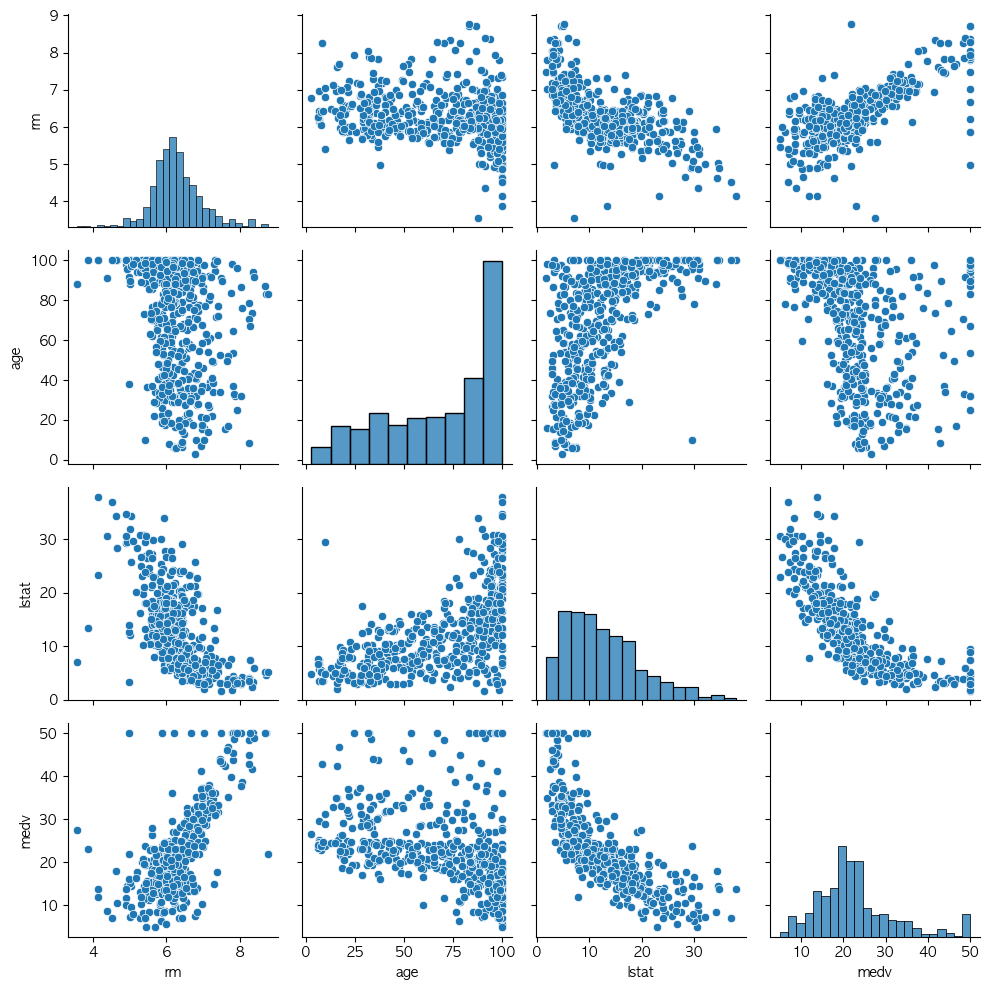

In [6]:
# 산점도 행렬
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.pairplot(df[['rm', 'age', 'lstat', 'medv']])

plt.tight_layout()

In [7]:
# 상관계수 구하기: 일부만 보기
print(df.corr().iloc[:3, :3])

           crim        zn     indus
crim   1.000000 -0.200469  0.406583
zn    -0.200469  1.000000 -0.533828
indus  0.406583 -0.533828  1.000000


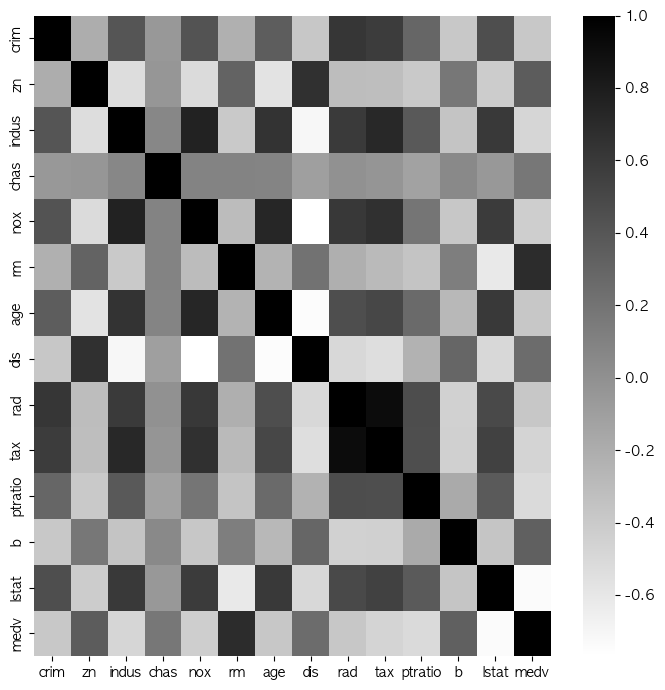

In [8]:
# 그래프 표현: 열지도
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(df.corr(), cmap='binary' , ax=ax)
plt.tight_layout()

## 분산분석 기법에 의한 모델 선택

In [9]:
# 기호 정의
xvars = ['indus', 'rm', 'tax', 'ptratio', 'lstat', 'chas', 'dis' ]
fmla = 'medv~' + '+'.join(xvars)
reduced_fmla = 'medv~' + '+'.join(list(set(xvars) - {'tax'}))

# 완전 모델(full model) 적합
full_model = smf.ols(fmla, data=df).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     169.8
Date:                Mon, 12 May 2025   Prob (F-statistic):          1.55e-127
Time:                        11:17:45   Log-Likelihood:                -1531.6
No. Observations:                 506   AIC:                             3079.
Df Residuals:                     498   BIC:                             3113.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.6898      4.100      6.023      0.0

In [10]:
# 축소 모델 적합
reduced_model = smf.ols(reduced_fmla, data=df).fit()
reduced_model.rsquared.round(3)

np.float64(0.703)

In [11]:
# 모델 비교
print(sm.stats.anova_lm(reduced_model, full_model))

   df_resid           ssr  df_diff   ss_diff         F    Pr(>F)
0     499.0  12677.025717      0.0       NaN       NaN       NaN
1     498.0  12613.667328      1.0  63.35839  2.501452  0.114376


## 교차 검증

### 단순 교차검증

In [13]:
# 데이터 분할
# 훈련 데이터
np.random.seed(123)
index = np.random.choice(np.arange(len(df)), size=int(len(df)*0.7), replace=False)
train = df.iloc[index]
train.shape

(354, 14)

In [14]:
# 검증 데이터
non_index = list(set(np.arange(len(df)))-set(index))
valid = df.iloc[non_index]
valid.shape

(152, 14)

In [15]:
# 입력 변수 구성
xvars = list(set(df.columns) - {'medv'})

# 각 변수를 하나씩 적합하기
rss = []
for j in np.arange(len(xvars)):
    varname = xvars[j]
    fit = smf.ols('medv~'+varname, data=train).fit()
    pred = fit.predict(sm.add_constant(valid[varname]))
    tmp_rss = np.sum((valid['medv'].values-pred)**2)
    rss.append(tmp_rss)

# 최소값을 주는 변수
xvars[np.nanargmin(rss)]

'rm'

### K-겹 교차검증

In [16]:
# 필요한 패키지
from sklearn.model_selection import KFold

# 폴더 정의
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
X = df[xvars]
y = df['medv']
kf.get_n_splits(X, y)

5

In [17]:
# 결과 배열 정의
mm = np.zeros(shape=(num_folds, len(xvars)))

# 각 폴더에 대하여
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    # 각 변수에 대하여
    for j in np.arange(len(xvars)):
        varname = xvars[j]
        fit = smf.ols('medv~' + varname, data=pd.concat([X_train, y_train], axis=1)).fit()
        pred = fit.predict(sm.add_constant(X_valid[varname]))
        tmp_rss = np.sum((y_valid.values - pred) ** 2)
        mm[i, j] = tmp_rss

# 각 변수별로 잔차 제곱합 평균 구하기
rss_mean = np.mean(mm, axis=0)
np.round(rss_mean, 3)

array([7449.084, 7346.338, 7003.566, 6391.593, 8350.58 , 8030.554,
       7342.039, 3918.69 , 7498.508, 7616.267, 6707.85 , 6566.661,
       4438.803])

In [18]:
# 최소값을 주는 변수
xvars[np.argmin(rss_mean)]

'lstat'

## 전진 선택

In [19]:
# 필요한 패키지
import itertools

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 데이터 구성
xvars = list(set(df.columns) - {'medv'})
xvars.sort()

X = df[xvars]
y = df['medv']

# 변수의 개수
k = len(xvars)
k

13

In [20]:
#
# 전진 선택 알고리즘: 후보 모형 구성하기 (statsmodels 이용)
#

# 남아있는 변수 리스트 및 선정된 변수 리스트 정의하기
remaining_features = list(X.columns.values)
features = []

# 색인이 0 부터 시작하므로 처음 값을 무한대로 정의
RSS_list, R_squared_list = [np.inf], [np.inf]

# 특징 리스트는 사전으로 정의: 키는 변수의 개수
features_list = dict()

# 알고리즘

# 변수의 개수 별로
for i in np.arange(1, k + 1):
    best_RSS = np.inf

    # 남아 있는 변수 1개씩 추가
    for combi in itertools.combinations(remaining_features, 1):
        
        # 회귀 모형 적합
        testing_features = list(combi) + features
        fit = sm.OLS(y, sm.add_constant(X[testing_features])).fit()
        RSS = fit.ssr
        R_squared = fit.rsquared
        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            # 튜플이므로 앞의 1개
            best_feature = combi[0]

    # 결과 갱신
    features.append(best_feature)
    remaining_features.remove(best_feature)

    # 결과 저장
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

# 결과 보기
[(features_list[i], RSS_list[i].round(1)) for i in np.arange(1, 5)]

[(['lstat'], np.float64(19472.4)),
 (['lstat', 'rm'], np.float64(15439.3)),
 (['lstat', 'rm', 'ptratio'], np.float64(13728.0)),
 (['lstat', 'rm', 'ptratio', 'dis'], np.float64(13228.9))]

In [21]:
# 결과 데이터 구성
rdf = pd.concat([pd.DataFrame({'features':features_list}),
                 pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})],
                axis=1, join='inner')
rdf['num_features'] = rdf.index
print(rdf.head(3))

               features           RSS  R_squared  num_features
1               [lstat]  19472.381418   0.544146             1
2           [lstat, rm]  15439.309201   0.638562             2
3  [lstat, rm, ptratio]  13727.985314   0.678624             3


In [22]:
# 벌점화된 통계량에 의한 변수 선택

#  결과 데이터로부터 AIC, BIC and R-square adjusted 계산
p = len(xvars) + 1
n = len(y)

rdf['AIC'] = n * np.log(rdf['RSS']/n) + 2*p + n + 2
rdf['BIC'] = n * np.log(rdf['RSS']/n) +p*np.log(n)
rdf['adj_R_squared'] = 1 - (n-1)*(1-rdf['R_squared'])/(n-p)
print(rdf.head(3))

               features           RSS  R_squared  num_features          AIC  \
1               [lstat]  19472.381418   0.544146             1  2383.009161   
2           [lstat, rm]  15439.309201   0.638562             2  2265.576519   
3  [lstat, rm, ptratio]  13727.985314   0.678624             3  2206.131472   

           BIC  adj_R_squared  
1  1934.180675       0.532101  
2  1816.748032       0.629011  
3  1757.302985       0.670133  


Text(0.5, 0.98, '$AIC, BIC, Adjusted-R^2$')

<Figure size 1800x600 with 0 Axes>

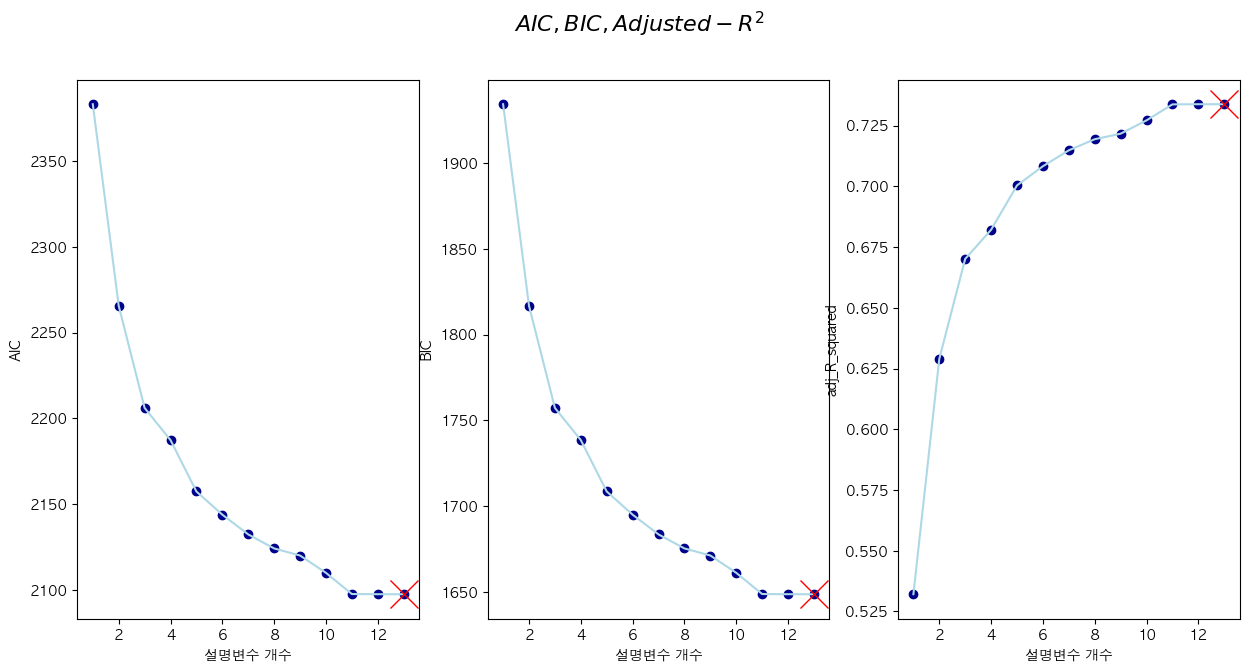

In [23]:
# 그림으로 표현
vars = ['AIC','BIC','adj_R_squared']
fig = plt.figure(figsize = (18,6))

fig, ax = plt.subplots(figsize=(15, 7), ncols=3)

for i, v in enumerate(vars):
    ax[i].plot(rdf['num_features'], rdf[v], color = 'lightblue')
    ax[i].scatter(rdf['num_features'], rdf[v], color = 'darkblue')
    if v == 'adj_R_squared':
        ax[i].plot(rdf[v].idxmax(),rdf[v].max(), marker = 'x', markersize = 20, color='red')
    else:
        ax[i].plot(rdf[v].idxmin(),rdf[v].min(), marker = 'x', markersize = 20, color='red')
    ax[i].set_xlabel('설명변수 개수')
    ax[i].set_ylabel(v)

plt.suptitle(r'$AIC, BIC, Adjusted-R^2$', fontsize = 16)
# plt.tight_layout()

In [24]:
# 교차 검증

# 폴더 정의
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)
X = df[xvars]
y = df['medv']

# 폴더 갯수
kf.get_n_splits(X, y)

5

In [25]:
# 교차 검증 알고리즘

# 결과 행렬 정의
result_list = []

# 각 폴더에 대하여
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    tmp_list = []
    
    # 각 변수 그룹에 대하여
    for j in np.arange(len(rdf)):
        vars = rdf.iloc[j]['features']
        fit = sm.OLS(y_train, sm.add_constant(X_train[vars])).fit()
        RSS = np.sum((y_valid - fit.predict(sm.add_constant(X_valid[vars])))**2)
        R_squared = 1 - RSS / np.sum((y_valid - np.mean(y_valid))**2)
        tmp_list.append(RSS)
    result_list.append(tmp_list)

result_list = np.array(result_list)

# 각 변수별로 잔차 제곱합 평균 구하기
rss_mean = np.nanmean(result_list, axis=0)

# 최소값을 주는 변수 목록
min_index = np.nanargmin(rss_mean)
rdf.iloc[min_index]['features']

['lstat',
 'rm',
 'ptratio',
 'dis',
 'nox',
 'chas',
 'b',
 'zn',
 'crim',
 'rad',
 'tax']

In [26]:
rdf.iloc[min_index]['num_features']

np.int64(11)

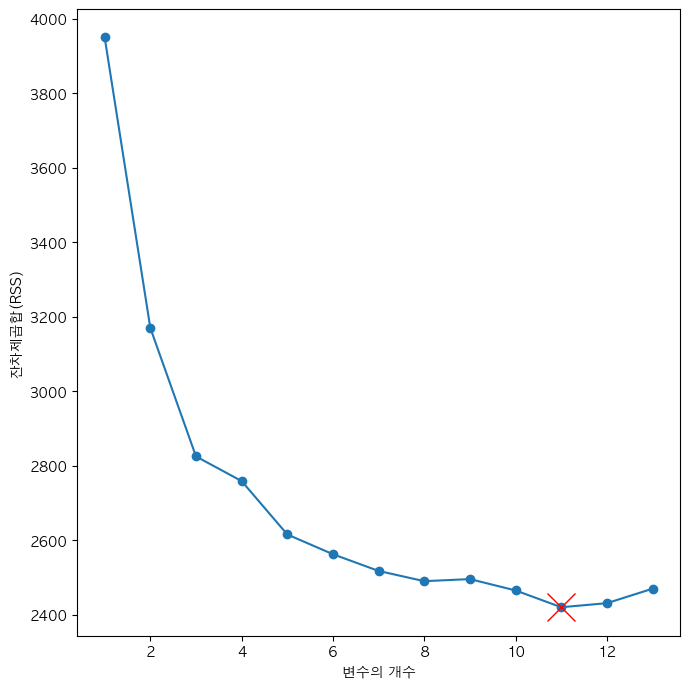

In [27]:
# 그림으로 표현
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(rdf.num_features, rss_mean)
ax.scatter(rdf.num_features, rss_mean, marker='o')
ax.plot(rdf.iloc[min_index]['num_features'], rss_mean[min_index], marker = 'x', markersize = 20, color='red')
ax.set_xlabel('변수의 개수')
ax.set_ylabel('잔차제곱합(RSS)')

plt.tight_layout()

## 후진 제거

In [28]:
# 데이터 구성
X = df[xvars]
y = df['medv']
k = len(xvars)

# 변수 리스트
remaining_features = list(X.columns.values)

# 사용될 리스트 
RSS_list, R_squared_list, features_list = [], [], []

In [29]:
# 후보 변수 구성 알고리즘
# 변수의 개수 별로
for i in np.arange(k, 0, -1):
    best_RSS = np.inf

    # 남아 있는 변수 1개씩 추가
    for combi in itertools.combinations(remaining_features, i):

        # 회귀 모형 적합
        testing_features = list(combi)
        fit = sm.OLS(y, sm.add_constant(X[testing_features])).fit()
        RSS = fit.ssr
        R_squared = fit.rsquared

        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            best_feature = list(combi)

    # 결과 갱신
    remaining_features = best_feature

    # 결과 저장
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list.append(best_feature)

    # 결과 데이터 구성
rdf = pd.DataFrame({'features':features_list, 'RSS':RSS_list, 'R_squared': R_squared_list})
rdf['num_features'] = rdf['features'].str.len()
print(rdf.head(3))

                                            features           RSS  R_squared  \
0  [age, b, chas, crim, dis, indus, lstat, nox, p...  11078.784578   0.740643   
1  [b, chas, crim, dis, indus, lstat, nox, ptrati...  11078.846412   0.740641   
2  [b, chas, crim, dis, lstat, nox, ptratio, rad,...  11081.363952   0.740582   

   num_features  
0            13  
1            12  
2            11  


In [30]:
# 적합 통계량 계산
# AIC, BIC and R-square adjusted 계산
p = len(xvars) + 1
n = len(y)

rdf['AIC'] = n * np.log(rdf['RSS']/n) + 2*p + n + 2
rdf['BIC'] = n * np.log(rdf['RSS']/n) +p*np.log(n)
rdf['adj_R_squared'] = 1 - (n-1)*(1-rdf['R_squared'])/(n-p)
print(rdf.head(3))

                                            features           RSS  R_squared  \
0  [age, b, chas, crim, dis, indus, lstat, nox, p...  11078.784578   0.740643   
1  [b, chas, crim, dis, indus, lstat, nox, ptrati...  11078.846412   0.740641   
2  [b, chas, crim, dis, lstat, nox, ptratio, rad,...  11081.363952   0.740582   

   num_features          AIC          BIC  adj_R_squared  
0            13  2097.642798  1648.814312       0.733790  
1            12  2097.645623  1648.817136       0.733788  
2            11  2097.760592  1648.932106       0.733728  


Text(0.5, 0.98, '$AIC, BIC, Adjusted-R^2$')

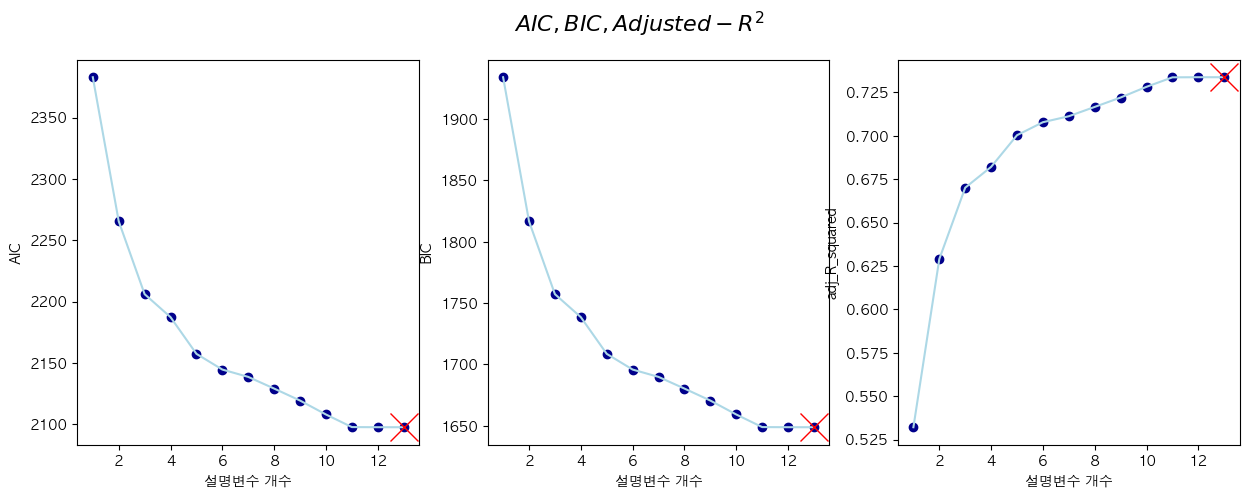

In [31]:
# 그림으로 표현
vars = ['AIC','BIC','adj_R_squared']

fig, ax = plt.subplots(figsize=(15, 5), ncols=3)
for i, v in enumerate(vars):
    ax[i].plot(rdf['num_features'], rdf[v], color = 'lightblue')
    ax[i].scatter(rdf['num_features'], rdf[v], color = 'darkblue')
    if v == 'adj_R_squared':
        ax[i].plot(rdf.iloc[rdf[v].idxmax()]['num_features'],rdf[v].max(), marker = 'x', markersize = 20, color='red')
    else:
        ax[i].plot(rdf.iloc[rdf[v].idxmin()]['num_features'],rdf[v].min(), marker = 'x', markersize = 20, color='red')
    ax[i].set_xlabel('설명변수 개수')
    ax[i].set_ylabel(v)

plt.suptitle(r'$AIC, BIC, Adjusted-R^2$', fontsize = 16)
# plt.tight_layout()

In [32]:
# 데이터 표준화
scaled_df = (df - np.mean(df, axis=0))/np.std(df, axis=0)

In [33]:
# 교차 검증 알고리즘
# 폴더 정의
num_folds = 5
np.random.seed(123)
kf = KFold(n_splits=num_folds, shuffle=True)
X = scaled_df[xvars]
y = scaled_df['medv']

# 폴더 갯수
kf.get_n_splits(X, y)

5

In [34]:
# 결과 행렬 정의
result_list = []

# 알고리즘
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    tmp_list = []
    
    # 각 변수 리스트에 대하여
    for j in np.arange(len(rdf)):
        vars = rdf.iloc[j]['features']
        fit = sm.OLS(y_train, sm.add_constant(X_train[vars])).fit()
        RSS = np.sum((y_valid - fit.predict(sm.add_constant(X_valid[vars])))**2)
        R_squared = 1 - RSS / np.sum((y_valid - np.mean(y_valid))**2)
        tmp_list.append(RSS)
    result_list.append(tmp_list)

result_list = np.array(result_list)

# 각 변수리스트 별로 잔차 제곱합 평균 구하기
rss_mean = np.nanmean(result_list, axis=0)

In [35]:
# 최소값을 주는 변수 목록
min_index = np.nanargmin(rss_mean)
rdf.iloc[min_index]['features']

['b',
 'chas',
 'crim',
 'dis',
 'lstat',
 'nox',
 'ptratio',
 'rad',
 'rm',
 'tax',
 'zn']

In [36]:
# 최소값을 주는 변수 개수
min_num_vars = rdf.iloc[min_index]['num_features']
min_num_vars

np.int64(11)

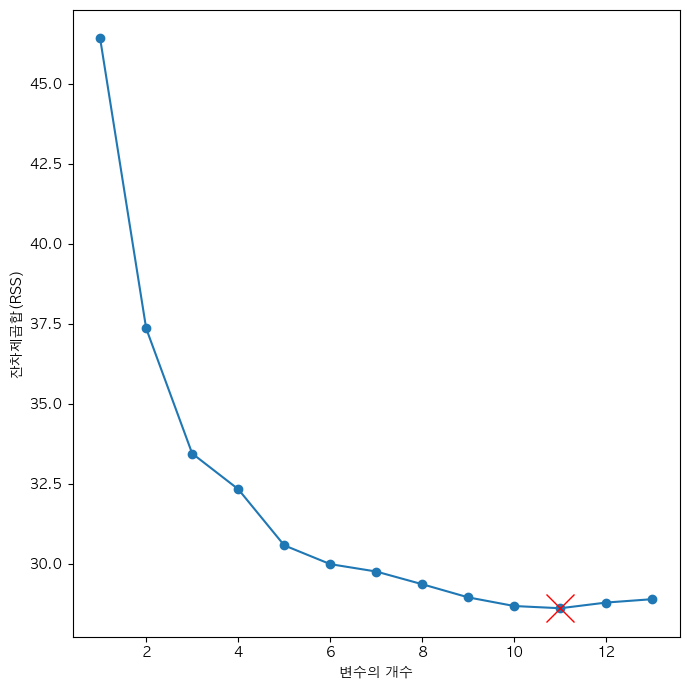

In [37]:
# 그림으로 표현
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(rdf['num_features'], rss_mean)
ax.scatter(rdf['num_features'], rss_mean, marker='o')
ax.plot(min_num_vars, rss_mean[min_index], marker = 'x', markersize = 20, color='red')
ax.set_xlabel('변수의 개수')
ax.set_ylabel('잔차제곱합(RSS)')

plt.tight_layout()

In [38]:
# 선택되지 않은 변수 목록
del_vars = list(set(xvars) - set(rdf.iloc[min_index]['features']))
del_vars

['age', 'indus']

<Figure size 700x700 with 0 Axes>

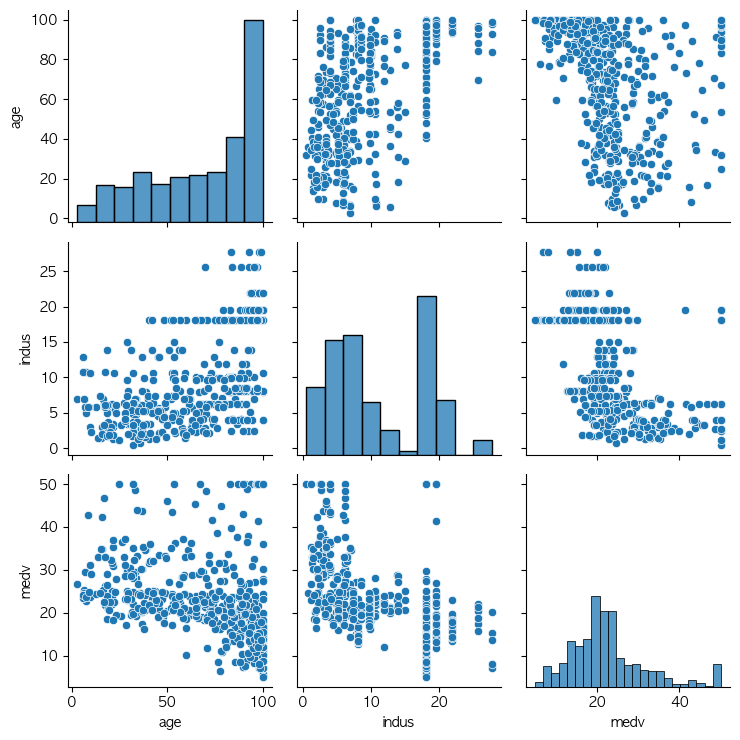

In [39]:
# 산점도로 확인
import seaborn as sns

plt.figure(figsize=(7, 7))

sns.pairplot(df[del_vars + ['medv']])

plt.tight_layout()

## 능형 회귀

In [40]:
# 필요한 패키지
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

In [41]:
# 능형회귀, 라쏘회귀 적합을 위한 데이터 전 처리
# 변수 리스트 구성하기
target_var = "medv"
input_vars = list(df.columns)
input_vars.remove(target_var)

# 표준화: 표준편차로 나누기
sdf = (df - np.mean(df, axis=0)) / np.std(df, ddof=1, axis=0)

# X, y 분리
X = sdf[input_vars].values
y = sdf[target_var].values

In [42]:
np.mean(df - np.mean(df, axis=0), axis=0)

crim      -4.493551e-16
zn         7.863714e-16
indus      1.909759e-15
chas      -1.579764e-17
nox       -2.457411e-17
rm        -7.021173e-17
age       -5.167584e-15
dis       -1.685082e-16
rad        0.000000e+00
tax        4.313809e-14
ptratio   -8.987102e-16
b         -6.470713e-14
lstat     -2.246775e-15
medv      -4.718228e-15
dtype: float64

In [43]:
a = [1, 2, 3]
np.std(a)

np.float64(0.816496580927726)

In [44]:

la.norm(a - np.mean(a))

1.4142135623730951

In [45]:
np.sqrt(np.dot(a - np.mean(a), a - np.mean(a))/3)

np.float64(0.816496580927726)

In [46]:
la.norm(df - np.mean(df, axis=0), axis=0)


array([1.93295685e+02, 5.24106946e+02, 1.54167258e+02, 5.70780618e+00,
       2.60402689e+00, 1.57893565e+01, 6.32566986e+02, 4.73199498e+01,
       1.95671318e+02, 3.78740063e+03, 4.86510997e+01, 2.05159691e+03,
       1.60475399e+02, 2.06679209e+02])

In [47]:
np.std(df, axis=0)

crim         8.593041
zn          23.299396
indus        6.853571
chas         0.253743
nox          0.115763
rm           0.701923
age         28.121033
dis          2.103628
rad          8.698651
tax        168.370495
ptratio      2.162805
b           91.204607
lstat        7.134002
medv         9.188012
dtype: float64

In [48]:
np.diag(X.T @ X)

array([505., 505., 505., 505., 505., 505., 505., 505., 505., 505., 505.,
       505., 505.])

In [49]:
X

array([[-0.41936693,  0.28454827, -1.28663623, ..., -1.45755797,
         0.44061589, -1.07449897],
       [-0.41692667, -0.48724019, -0.59279438, ..., -0.3027945 ,
         0.44061589, -0.49195252],
       [-0.416929  , -0.48724019, -0.59279438, ..., -0.3027945 ,
         0.39603507, -1.20753241],
       ...,
       [-0.41303783, -0.48724019,  0.11562398, ...,  1.17530274,
         0.44061589, -0.98207574],
       [-0.40736095, -0.48724019,  0.11562398, ...,  1.17530274,
         0.40282626, -0.86444617],
       [-0.41458988, -0.48724019,  0.11562398, ...,  1.17530274,
         0.44061589, -0.66839688]], shape=(506, 13))

In [50]:
np.sum(df.iloc[:,0].values**2)

np.float64(43970.3435551508)

In [51]:
ssdf = df / np.diag(df.values.T @ df.values)

np.diag(ssdf.values.T @ ssdf.values)


array([2.27426015e-05, 2.94092563e-06, 1.15572692e-05, 2.85714286e-02,
       6.15496806e-03, 4.94203042e-05, 3.59762101e-07, 1.04967412e-04,
       1.18441312e-05, 1.01344706e-08, 5.72364207e-06, 1.45813979e-08,
       9.36654450e-06, 3.33749029e-06])

### 능형회귀 적합

In [52]:
# 추정해야 할 모수 (절편 제외)
nparams = len(input_vars)

# 람다 값의 범위
lambdas = np.logspace(-7, 12, 100, base=np.e)

# 모수 값을 넣기 위한 행렬 생성: 하나의 열이 동일한 람다 값
coefficients = np.zeros(shape=(nparams, len(lambdas)))

# 평균제곱오차 값을 넣기 위한 벡터 생성
costs = np.zeros_like(lambdas, float)

# 교차 검증에 의한 평균제곱오차 계산
num_folders = 5

for i, l in enumerate(lambdas):
    # 람다 값에 따른 모형의 구성
    ridge = Ridge(alpha=l, fit_intercept=False)
    ridge.fit(X, y)
    coefficients[:, i] = ridge.coef_
    
    # 각 람다 값에 따른 교차 검증에 의한 평균제곱오차의 계산
    fold_costs = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # 각 폴더에 대한 모형 적합
        ridge = Ridge(alpha=l, fit_intercept=False)
        ridge.fit(X_train, y_train)
        
        # 평균제곱오차 계산
        pred = ridge.predict(X_valid)
        cost = np.sum((pred - y_valid)**2) / len(y_valid)
        fold_costs.append(cost)
        
    # 평균제곱오차 평균계산    
    costs[i] = np.mean(fold_costs) 

# 평균제곱오차를 최소화 하는 인덱스 
min_index = np.argmin(costs)
min_index

np.int64(47)

In [53]:
# 람다 값
lambdas[min_index].round(5)

np.float64(7.53985)

In [54]:
# 로그 람다 값
np.log(lambdas[min_index]).round(3)

np.float64(2.02)

In [55]:
# 최소값을 줄 때의 표준화된 회귀계수 값들
res = pd.DataFrame({'Variable':input_vars, 'Coefficient':coefficients[:, min_index]}).sort_values(by='Coefficient')
print(res.round(3))

   Variable  Coefficient
12    lstat       -0.397
7       dis       -0.317
10  ptratio       -0.218
4       nox       -0.203
9       tax       -0.181
0      crim       -0.095
6       age       -0.002
2     indus       -0.001
3      chas        0.076
11        b        0.092
1        zn        0.107
8       rad        0.241
5        rm        0.297


## 라쏘 회귀

### 라쏘 회귀 적합

In [56]:
# 추정해야 할 모수 (절편 제외)
nparams = len(input_vars)

# 람다 값의 범위
lambdas = np.logspace(-10, 5, 100, base=np.exp(1))

# 모수 값을 넣기 위한 행렬 생성: 하나의 열이 동일한 람다 값
coefficients = np.zeros(shape=(nparams, len(lambdas)))

# 평균제곱오차 값을 넣기 위한 벡터 생성
costs = np.zeros_like(lambdas, float)

# 교차 검증에 의한 평균제곱오차 계산
num_folders = 5

# lasso 회귀 적합 및 평균제곱오차 계산
for i, l in enumerate(lambdas):
    lasso = Lasso(alpha=l, fit_intercept=False)
    lasso.fit(X, y)
    coefficients[:, i] = lasso.coef_
        
    # 각 람다 값에 따른 교차 검증에 의한 평균제곱오차 계산
    fold_costs = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # 각 폴더에 대한 모형 적합
        lasso = Lasso(alpha=l, fit_intercept=False)
        lasso.fit(X_train, y_train)
        
        # 평균제곱오차 계산
        pred = lasso.predict(X_valid)
        cost = np.sum((pred - y_valid)**2) / len(y_valid)
        fold_costs.append(cost)
        
    # 평균제곱오차의 평균 계산    
    costs[i] = np.mean(fold_costs) 

# 평균제곱오차를  최소화 하는 인덱스
min_index = np.argmin(costs)
min_index

np.int64(26)

In [57]:
# 람다 값
min_lambda = lambdas[min_index]
min_lambda

# 로그 단위로 변환
min_log_lambda = np.log(min_lambda)

np.round([min_lambda,min_log_lambda], 5)

array([ 2.33000e-03, -6.06061e+00])

In [58]:
# 최소값을 줄 때의 표준화된 회귀계수 값들
res = pd.DataFrame({'Variable':input_vars, 'Coefficient':coefficients[:, min_index]}).sort_values(by='Coefficient')
print(res)

   Variable  Coefficient
12    lstat    -0.405697
7       dis    -0.324987
10  ptratio    -0.219876
4       nox    -0.208698
9       tax    -0.189174
0      crim    -0.094369
2     indus     0.000000
6       age    -0.000000
3      chas     0.074332
11        b     0.090229
1        zn     0.107855
8       rad     0.250554
5        rm     0.294126
